In [32]:
from typing import List, Optional, Dict
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import spaces

from dataclasses import dataclass

from sklearn.preprocessing import StandardScaler

from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [33]:
TICKERS = ["MTUM", "VLUE", "QUAL", "USMV", "IWM"]
START, END = "2014-01-01", "2026-01-31"

TRAIN_START, TRAIN_END = "2014-01-01", "2019-12-31"
TEST_START, TEST_END   = "2020-01-01", "2026-01-31"

np.random.seed(0)

In [34]:
def download_price_data(tickers: List[str], start: str, end: str) -> pd.DataFrame:
    data = yf.download(tickers, start=start, end=end, progress=False)["Close"]
    if isinstance(data, pd.Series):
        data = data.to_frame()
    data = data.ffill()
    data = data.dropna(how="any")
    return data

prices = download_price_data(TICKERS, START, END)
rets = prices.pct_change().dropna()
rets.head()

Ticker,IWM,MTUM,QUAL,USMV,VLUE
Date,,,,,
2014-01-03,0.005083,0.001683,-0.001961,-0.000284,-0.001182
2014-01-06,-0.008109,-0.002184,-0.003929,-0.002277,-0.000169
2014-01-07,0.008351,0.008252,0.008069,0.005704,0.005581
2014-01-08,0.001308,0.007349,-0.000356,-0.000283,0.000000
2014-01-09,0.000261,0.001824,-0.000534,0.001418,-0.002186


In [35]:
def make_features(prices: pd.DataFrame) -> pd.DataFrame:
    px = prices.copy()
    r = px.pct_change()

    # windows
    w_mom = 20
    w_vol = 20
    w_ma  = 50
    w_dd  = 60

    # momentum: past cumulative return
    mom = (1.0 + r).rolling(w_mom).apply(lambda x: np.prod(x) - 1.0, raw=True)

    # volatility: rolling std
    vol = r.rolling(w_vol).std()

    # MA deviation
    ma = px.rolling(w_ma).mean()
    ma_dev = (px / ma - 1.0)

    # drawdown: peak-to-trough over window (approx using rolling max)
    roll_max = px.rolling(w_dd).max()
    dd = px / roll_max - 1.0

    # cross-sectional ranks (each day)
    def cs_rank(df: pd.DataFrame) -> pd.DataFrame:
        # rank across assets -> [-1, 1]
        rk = df.rank(axis=1, method="average")
        u = (rk - 0.5) / rk.shape[1]
        return 2.0*u - 1.0

    mom_cs = cs_rank(mom)
    vol_cs = cs_rank(vol)
    ma_cs  = cs_rank(ma_dev)
    dd_cs  = cs_rank(dd)

    # concatenate features (flatten naming)
    feats = []
    for name, X in [
        ("mom", mom),
        ("vol", vol),
        ("ma_dev", ma_dev),
        ("dd", dd),
        ("mom_cs", mom_cs),
        ("vol_cs", vol_cs),
        ("ma_cs", ma_cs),
        ("dd_cs", dd_cs),
    ]:
        tmp = X.copy()
        tmp.columns = [f"{name}_{c}" for c in tmp.columns]
        feats.append(tmp)

    F = pd.concat(feats, axis=1)
    F = F.shift(1)
    F = F.dropna()
    return F

F = make_features(prices)
F.head()

,mom_IWM,mom_MTUM,mom_QUAL,mom_USMV,mom_VLUE,vol_IWM,vol_MTUM,vol_QUAL,vol_USMV,vol_VLUE,...,ma_cs_IWM,ma_cs_MTUM,ma_cs_QUAL,ma_cs_USMV,ma_cs_VLUE,dd_cs_IWM,dd_cs_MTUM,dd_cs_QUAL,dd_cs_USMV,dd_cs_VLUE
Date,,,,,,,,,,,,,,,,,,,,,
2014-03-31,-0.024974,-0.043792,-0.014053,-0.001042,0.011795,0.009496,0.008699,0.007045,0.005136,0.006315,...,-0.4,-0.8,0.0,0.4,0.8,-0.4,-0.8,0.0,0.4,0.8
2014-04-01,-0.002135,-0.025782,0.004866,0.015536,0.026425,0.010351,0.008970,0.007074,0.005287,0.006196,...,-0.4,-0.8,0.0,0.4,0.8,-0.4,-0.8,0.0,0.4,0.8
2014-04-02,-0.013817,-0.033938,-0.002172,0.002611,0.016750,0.009083,0.008044,0.006334,0.004323,0.005385,...,0.0,-0.8,-0.4,0.4,0.8,-0.4,-0.8,0.0,0.6,0.6
2014-04-03,-0.008803,-0.028511,0.003089,0.007341,0.017257,0.009156,0.008260,0.006332,0.004316,0.005380,...,0.4,-0.8,-0.4,0.0,0.8,-0.4,-0.8,0.4,0.4,0.4
2014-04-04,-0.018686,-0.035849,-0.001480,0.008178,0.013213,0.009411,0.008453,0.006394,0.004311,0.005332,...,-0.4,-0.8,0.0,0.4,0.8,-0.4,-0.8,0.0,0.6,0.6


In [36]:
from sklearn.preprocessing import StandardScaler

# retsもFに合わせて同期
rets_aligned = rets.loc[F.index].copy()

# split
F_tr = F.loc[TRAIN_START:TRAIN_END].copy()
F_te = F.loc[TEST_START:TEST_END].copy()

R_tr = rets_aligned.loc[TRAIN_START:TRAIN_END].copy()
R_te = rets_aligned.loc[TEST_START:TEST_END].copy()

# scaler fit on train only
scaler = StandardScaler()
F_tr_s = pd.DataFrame(scaler.fit_transform(F_tr), index=F_tr.index, columns=F_tr.columns)
F_te_s = pd.DataFrame(scaler.transform(F_te), index=F_te.index, columns=F_te.columns)

F_tr_s.shape, F_te_s.shape, R_tr.shape, R_te.shape

((1450, 40), (1520, 40), (1450, 5), (1520, 5))

In [37]:
# ============================================================
# 0) Imports
# ============================================================
from dataclasses import dataclass
from typing import Optional, Dict, Any, List, Tuple
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy

import matplotlib.pyplot as plt

# ============================================================
# 1) Helpers
# ============================================================
def softmax(x: np.ndarray, tau: float = 1.0) -> np.ndarray:
    z = x / max(tau, 1e-12)
    z = z - np.max(z)
    e = np.exp(z)
    return (e / (e.sum() + 1e-12)).astype(np.float32)

def make_monthly_target_vol(index_daily: pd.DatetimeIndex, target_ann: float = 0.12) -> pd.Series:
    months = pd.PeriodIndex(index_daily, freq="M")
    uniq = pd.Index(sorted(months.unique()))
    return pd.Series(target_ann, index=uniq, name="target_vol_ann")

def ann_stats(r: pd.Series, freq=252) -> pd.Series:
    r = r.dropna()
    ann_ret = (1.0 + r).prod() ** (freq / len(r)) - 1.0
    ann_vol = r.std(ddof=0) * np.sqrt(freq)
    sharpe  = r.mean() / (r.std(ddof=0) + 1e-12) * np.sqrt(freq)
    nav = (1.0 + r).cumprod()
    dd  = nav / nav.cummax() - 1.0
    return pd.Series({
        "ann_return": ann_ret,
        "ann_vol": ann_vol,
        "sharpe": sharpe,
        "max_drawdown": dd.min()
    })

# ============================================================
# 2) Config
# ============================================================
@dataclass
class EnvConfig:
    lookback: int = 20
    tau: float = 1.0

    rebalance_freq: str = "daily" # {"daily", "weekly", "monthly"}

    # vol targeting switch
    vol_target_mode: str = "month_fixed_rv"  # {"none","daily_cov","month_fixed_rv"}
    target_vol_ann_default: float = 0.12
    leverage_max: float = 3.0

    # daily_cov params
    cov_win: int = 20

    # month_fixed_rv params
    rv_win: int = 20
    init_lev_from_eqw: bool = True

    # reward switch
    reward_mode: str = "log"  # {"log","diff_sharpe","meanvar"}
    eta: float = 0.01         # for diff_sharpe EMA speed
    meanvar_lambda: float = 5.0  # for meanvar

    # numerical
    eps: float = 1e-12

@dataclass
class TrainConfig:
    total_timesteps: int = 300_000
    seed: int = 0
    eval_freq: int = 25_000

    # PPO hyperparams (stable baseline)
    n_steps: int = 2048
    batch_size: int = 256
    lr: float = 3e-4
    gamma: float = 0.99
    gae_lambda: float = 0.95
    clip_range: float = 0.2
    ent_coef: float = 0.0

def build_rebalance_mask(dates: pd.DatetimeIndex, freq: str) -> np.ndarray:
    """
    mask[t] = True なら、t日の引けでリバランスして t+1 から新ウェイト適用
    execution_lag=1 と整合
    """
    freq = freq.lower()
    T = len(dates)
    mask = np.zeros(T, dtype=bool)

    if freq == "daily":
        mask[:] = True
        return mask

    if freq == "weekly":
        # 金曜(weekday=4)をリバランス日とする（市場休日で金曜が無い週は、その週はスキップ）
        wd = pd.Series(dates).dt.weekday.to_numpy()
        mask[:] = (wd == 4)
        return mask

    if freq == "monthly":
        # 月末最終営業日: 次の日付の月が変わる日を月末とみなす
        # t が月末最終営業日 => period(t) != period(t+1)
        per = pd.PeriodIndex(dates, freq="M")
        mask[:-1] = (per[:-1] != per[1:])
        mask[-1] = True  # 最終日は便宜上True（ただし終端近くではstep終わるので影響小）
        return mask

    raise ValueError(f"Unknown rebalance_freq: {freq}")

# ============================================================
# 3) Callbacks (learning curve)
# ============================================================
class EpisodeReturnCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.ep_hist = {"timesteps": [], "ep_reward": [], "ep_length": []}

    def _on_step(self) -> bool:
        infos = self.locals.get("infos", None)
        if infos is None:
            return True
        if isinstance(infos, dict):
            infos = [infos]
        for info in infos:
            if isinstance(info, dict) and ("episode" in info):
                ep = info["episode"]
                self.ep_hist["timesteps"].append(self.num_timesteps)
                self.ep_hist["ep_reward"].append(float(ep["r"]))
                self.ep_hist["ep_length"].append(int(ep["l"]))
        return True

    def to_frame(self):
        return pd.DataFrame(self.ep_hist)

class EvalLogCallback(BaseCallback):
    def __init__(self, eval_env, eval_freq=25_000, n_eval_episodes=1, verbose=0):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = int(eval_freq)
        self.n_eval_episodes = int(n_eval_episodes)
        self.eval_history = {"timesteps": [], "mean_reward": [], "std_reward": []}

    def _on_step(self) -> bool:
        if self.eval_freq > 0 and (self.num_timesteps % self.eval_freq == 0):
            mean_r, std_r = evaluate_policy(
                self.model,
                self.eval_env,
                n_eval_episodes=self.n_eval_episodes,
                deterministic=True,
                return_episode_rewards=False,
            )
            self.eval_history["timesteps"].append(self.num_timesteps)
            self.eval_history["mean_reward"].append(float(mean_r))
            self.eval_history["std_reward"].append(float(std_r))
        return True

    def to_frame(self):
        return pd.DataFrame(self.eval_history)

# ============================================================
# 4) Unified Environment
# ============================================================
class ETFUnifiedEnv(gym.Env):
    """
    Unified RL environment:
    - w_raw: softmax(action) long-only sum=1
    - execution lag=1 (reward uses returns[t])
    - vol targeting switch: none / daily_cov / month_fixed_rv
    - reward switch: log / diff_sharpe / meanvar
    """
    metadata = {"render_modes": []}

    def __init__(
        self,
        features: pd.DataFrame,
        returns: pd.DataFrame,
        cfg: EnvConfig,
        monthly_target_vol_ann: Optional[pd.Series] = None,  # PeriodIndex('M') if month_fixed_rv
    ):
        super().__init__()
        assert features.index.equals(returns.index)

        self.cfg = cfg

        self.F = features.to_numpy(dtype=np.float32)
        self.R = returns.to_numpy(dtype=np.float32)
        self.dates = returns.index
        self.assets = returns.columns.tolist()

        self.T = self.R.shape[0]
        self.n_assets = self.R.shape[1]
        self.n_feat = self.F.shape[1]

        self.monthly_target_vol_ann = monthly_target_vol_ann
        if self.monthly_target_vol_ann is None:
            # fallback: constant target for all months
            self.monthly_target_vol_ann = make_monthly_target_vol(self.dates, cfg.target_vol_ann_default)

        self.rebalance_mask = build_rebalance_mask(self.dates, cfg.rebalance_freq)

        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(cfg.lookback * self.n_feat,),
            dtype=np.float32
        )
        self.action_space = spaces.Box(
            low=-5.0, high=5.0,
            shape=(self.n_assets,),
            dtype=np.float32
        )

        # internal state
        self.t = None

        # month_fixed_rv states
        self.cur_month = None
        self.lev_m = None
        self.raw_ret_hist: List[float] = []

        # diff_sharpe states
        self.A = 0.0
        self.B = 0.0

        self.w_hold = None

    # -----------------
    # common utilities
    # -----------------
    def _obs(self) -> np.ndarray:
        L = self.cfg.lookback
        block = self.F[self.t - L:self.t]
        return block.reshape(-1).astype(np.float32)

    def _target_vol_day(self, month: pd.Period) -> float:
        # annual -> daily
        if month in self.monthly_target_vol_ann.index:
            ann = float(self.monthly_target_vol_ann.loc[month])
        else:
            ann = float(self.monthly_target_vol_ann.iloc[-1])
        return ann / np.sqrt(252.0)

    # -----------------
    # vol targeting (3 modes)
    # -----------------
    def _lev_none(self, w_raw: np.ndarray) -> float:
        return 1.0

    def _lev_daily_cov(self, w_raw: np.ndarray) -> float:
        W = self.cfg.cov_win
        # require enough history
        if self.t - W < 0:
            return 1.0
        Rw = np.nan_to_num(self.R[self.t - W:self.t], nan=0.0)
        cov = np.cov(Rw, rowvar=False, ddof=0) + np.eye(self.n_assets) * 1e-8
        var_p = float(w_raw @ cov @ w_raw)
        sig_p = np.sqrt(max(var_p, self.cfg.eps))
        target_day = self._target_vol_day(pd.Period(self.dates[self.t], freq="M"))
        lev = target_day / sig_p
        return float(np.clip(lev, 0.0, self.cfg.leverage_max))

    def _estimate_rv_from_hist(self) -> float:
        W = self.cfg.rv_win
        if len(self.raw_ret_hist) < W:
            return np.nan
        x = np.array(self.raw_ret_hist[-W:], dtype=np.float64)
        return float(np.std(x, ddof=0))

    def _compute_month_leverage(self, month: pd.Period) -> float:
        rv = self._estimate_rv_from_hist()
        if (not np.isfinite(rv)) or (rv <= self.cfg.eps):
            return 1.0
        lev = self._target_vol_day(month) / rv
        return float(np.clip(lev, 0.0, self.cfg.leverage_max))

    def _lev_month_fixed_rv(self, w_raw: np.ndarray) -> float:
        # leverage is month-fixed, so this returns current self.lev_m
        return float(self.lev_m)

    def _update_month_fixed_leverage_if_needed(self):
        month_now = pd.Period(self.dates[self.t], freq="M")
        if self.cur_month is None:
            self.cur_month = month_now
            self.lev_m = self._compute_month_leverage(month_now)
            return
        if month_now != self.cur_month:
            self.cur_month = month_now
            self.lev_m = self._compute_month_leverage(month_now)

    def _get_leverage(self, w_raw: np.ndarray) -> float:
        m = self.cfg.vol_target_mode
        if m == "none":
            return self._lev_none(w_raw)
        elif m == "daily_cov":
            return self._lev_daily_cov(w_raw)
        elif m == "month_fixed_rv":
            return self._lev_month_fixed_rv(w_raw)
        else:
            raise ValueError(f"Unknown vol_target_mode: {m}")

    # -----------------
    # reward (3 modes)
    # -----------------
    def _reward_log(self, rp: float) -> float:
        return float(np.log1p(rp))

    def _reward_diff_sharpe(self, rp: float) -> float:
        # Differential Sharpe (EMA)
        dA = rp - self.A
        dB = rp**2 - self.B
        num = self.B * dA - 0.5 * self.A * dB
        den = (self.B - self.A**2 + self.cfg.eps) ** 1.5
        r = float(num / den)
        self.A = self.A + self.cfg.eta * dA
        self.B = self.B + self.cfg.eta * dB
        return r

    def _reward_meanvar(self, rp: float) -> float:
        # mean-variance style (Sharpe近似の安定版)
        lam = float(self.cfg.meanvar_lambda)
        return float(rp - lam * (rp**2))

    def _compute_reward(self, rp: float) -> float:
        rm = self.cfg.reward_mode
        if rm == "log":
            return self._reward_log(rp)
        elif rm == "diff_sharpe":
            return self._reward_diff_sharpe(rp)
        elif rm == "meanvar":
            return self._reward_meanvar(rp)
        else:
            raise ValueError(f"Unknown reward_mode: {rm}")

    # -----------------
    # Gym API
    # -----------------
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        # start index must satisfy lookback and (cov_win / rv_win)
        t0 = self.cfg.lookback
        if self.cfg.vol_target_mode == "daily_cov":
            t0 = max(t0, self.cfg.cov_win)
        if self.cfg.vol_target_mode == "month_fixed_rv":
            t0 = max(t0, self.cfg.rv_win)

        if self.T <= t0 + 2:
            raise ValueError(
                f"Data too short after feature dropna. T={self.T}, start={t0}. "
                "Reduce lookback/windows or expand date range."
            )

        self.t = t0

        # reset month_fixed states
        self.cur_month = None
        self.lev_m = 1.0
        self.raw_ret_hist = []

        self.w_hold = np.ones(self.n_assets, dtype=np.float32) / self.n_assets

        # init raw_ret_hist using eqw (past only) to allow leverage at month start
        if self.cfg.vol_target_mode == "month_fixed_rv" and self.cfg.init_lev_from_eqw:
            w_eq = np.ones(self.n_assets, dtype=np.float64) / self.n_assets
            for k in range(self.t - self.cfg.rv_win, self.t):
                r_k = np.nan_to_num(self.R[k], nan=0.0).astype(np.float64)
                self.raw_ret_hist.append(float(w_eq @ r_k))
            self.cur_month = pd.Period(self.dates[self.t], freq="M")
            self.lev_m = self._compute_month_leverage(self.cur_month)

        # reset diff_sharpe state
        self.A = 0.0
        self.B = 0.0

        return self._obs(), {}

    def step(self, action):
        # month_fixed leverage update happens at time t (month boundary)
        if self.cfg.vol_target_mode == "month_fixed_rv":
            self._update_month_fixed_leverage_if_needed()
        
        # -------- rebalance logic --------
        rebalance_day = bool(self.rebalance_mask[self.t])  # decide at t, apply to t+1

        # action -> weights
        if rebalance_day:
            w_raw = softmax(action.astype(np.float32), tau=self.cfg.tau)
        else:
            w_raw = self.w_hold  # hold

        # execution lag=1: realized return at index t
        r_next = np.nan_to_num(self.R[self.t], nan=0.0)
        rp_raw = float(np.dot(w_raw, r_next))

        # update raw history for RV (month_fixed)
        if self.cfg.vol_target_mode == "month_fixed_rv":
            self.raw_ret_hist.append(rp_raw)

        # leverage
        lev = self._get_leverage(w_raw)
        rp = float(lev * rp_raw)

        # reward
        reward = self._compute_reward(rp)
        
        # commit holdings
        self.w_hold = w_raw.copy()

        # info
        info = {
            "date": self.dates[self.t],
            "rp_raw": rp_raw,
            "rp": rp,
            "lev": lev,
            **{f"w_{a}": float(w_raw[i]) for i, a in enumerate(self.assets)},
        }

        # advance
        self.t += 1
        terminated = (self.t >= self.T)
        truncated = False

        obs = self._obs() if not terminated else np.zeros(self.cfg.lookback * self.n_feat, dtype=np.float32)
        return obs, reward, terminated, truncated, info

# ============================================================
# 5) Runner: train + test rollout + curves
# ============================================================
def run_experiment(
    F_train: pd.DataFrame,
    R_train: pd.DataFrame,
    F_test: pd.DataFrame,
    R_test: pd.DataFrame,
    env_cfg: EnvConfig,
    tr_cfg: TrainConfig,
    monthly_target_vol_ann: Optional[pd.Series] = None
) -> Tuple[PPO, pd.DataFrame, pd.Series, pd.DataFrame, pd.DataFrame]:

    env_tr_raw = ETFUnifiedEnv(F_train, R_train, cfg=env_cfg, monthly_target_vol_ann=monthly_target_vol_ann)
    env_te_raw = ETFUnifiedEnv(F_test, R_test, cfg=env_cfg, monthly_target_vol_ann=monthly_target_vol_ann)

    env_tr = Monitor(env_tr_raw)
    env_te = Monitor(env_te_raw)

    cb_ep = EpisodeReturnCallback()
    cb_ev = EvalLogCallback(env_te, eval_freq=tr_cfg.eval_freq, n_eval_episodes=1)

    model = PPO(
        "MlpPolicy",
        env_tr,
        seed=tr_cfg.seed,
        verbose=1,
        n_steps=tr_cfg.n_steps,
        batch_size=tr_cfg.batch_size,
        learning_rate=tr_cfg.lr,
        gamma=tr_cfg.gamma,
        gae_lambda=tr_cfg.gae_lambda,
        clip_range=tr_cfg.clip_range,
        ent_coef=tr_cfg.ent_coef,
        tensorboard_log=None,
    )
    model.learn(total_timesteps=tr_cfg.total_timesteps, callback=[cb_ep, cb_ev])

    # test rollout
    obs, _ = env_te_raw.reset(seed=tr_cfg.seed)
    done = False
    rows = []
    while not done:
        act, _ = model.predict(obs, deterministic=True)
        obs, rew, done, _, info = env_te_raw.step(act)
        rows.append(info)

    df_strat = pd.DataFrame(rows).set_index("date")
    df_strat.index = pd.to_datetime(df_strat.index)

    # baseline: equal weight raw
    eqw_raw = pd.Series(R_test.loc[df_strat.index].mean(axis=1), index=df_strat.index, name="eqw_raw")

    ep_logs = cb_ep.to_frame()
    eval_logs = cb_ev.to_frame()

    # safety: df_strat 1-row guard
    if len(df_strat) <= 5:
        print("[WARN] df_strat length is very small:", len(df_strat))
        print("Check len(F_test), len(R_test), lookback/windows after dropna.")
    return model, df_strat, eqw_raw, ep_logs, eval_logs

# ============================================================
# 6) Plot utilities
# ============================================================
def plot_learning_curves(ep_logs: pd.DataFrame, eval_logs: pd.DataFrame):
    if len(eval_logs) > 0:
        plt.figure(figsize=(10,4))
        plt.plot(eval_logs["mean_reward"], marker="o")
        plt.title("Eval learning curve")
        plt.xlabel("timesteps"); plt.ylabel("mean_reward")
        plt.grid(True); plt.show()

    if len(ep_logs) > 0:
        plt.figure(figsize=(10,4))
        plt.plot(ep_logs["ep_reward"], marker="o")
        plt.title("Episode reward curve")
        plt.xlabel("timesteps"); plt.ylabel("episode reward")
        plt.grid(True); plt.show()

def plot_nav(df_strat: pd.DataFrame, eqw_raw: pd.Series):
    nav_rl = (1.0 + df_strat["rp"]).cumprod()
    nav_eq = (1.0 + eqw_raw).cumprod()

    plt.figure(figsize=(10,5))
    plt.plot(nav_rl.values, label="Strategy (rp)")
    plt.plot(nav_eq.values, label="Equal Weight (raw)")
    plt.title("Test NAV")
    plt.grid(True); plt.legend(); plt.show()

def summarize(df_strat: pd.DataFrame, eqw_raw: pd.Series) -> pd.DataFrame:
    s_rl = ann_stats(df_strat["rp"])
    s_eq = ann_stats(eqw_raw)
    return pd.DataFrame({"Strategy": s_rl, "EqualWeight": s_eq})


In [75]:
env_cfg = EnvConfig(
    vol_target_mode="daily_cov",
    reward_mode="log",
    rebalance_freq="monthly",
    target_vol_ann_default=0.10,
    leverage_max=3.0,
    rv_win=20,
    lookback=20,
    tau=1.0,
)

tr_cfg = TrainConfig(total_timesteps=3000_000, seed=0, eval_freq=25_000)

target_vol_m = make_monthly_target_vol(R_tr.index.union(R_te.index), target_ann=0.10)

model, df_strat, eqw_raw, ep_logs, eval_logs = run_experiment(
    F_tr_s, R_tr, F_te_s, R_te,
    env_cfg=env_cfg,
    tr_cfg=tr_cfg,
    monthly_target_vol_ann=target_vol_m
)

Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.43e+03 |
|    ep_rew_mean     | 0.571    |
| time/              |          |
|    fps             | 3620     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.43e+03    |
|    ep_rew_mean          | 0.563       |
| time/                   |             |
|    fps                  | 2996        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010877941 |
|    clip_fraction        | 0.0835      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.08       |
|    explained_varia

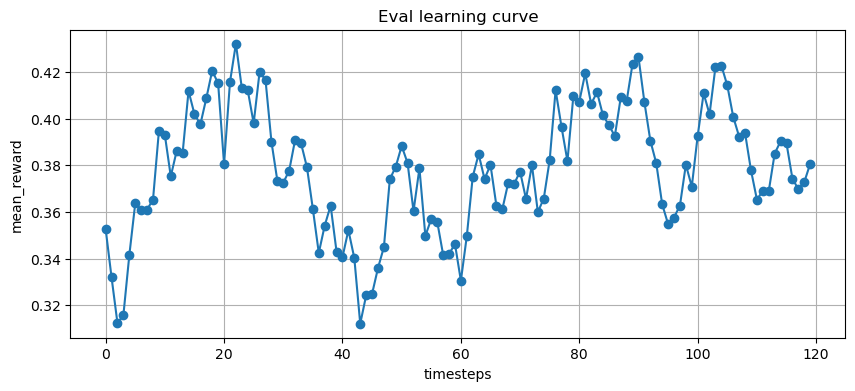

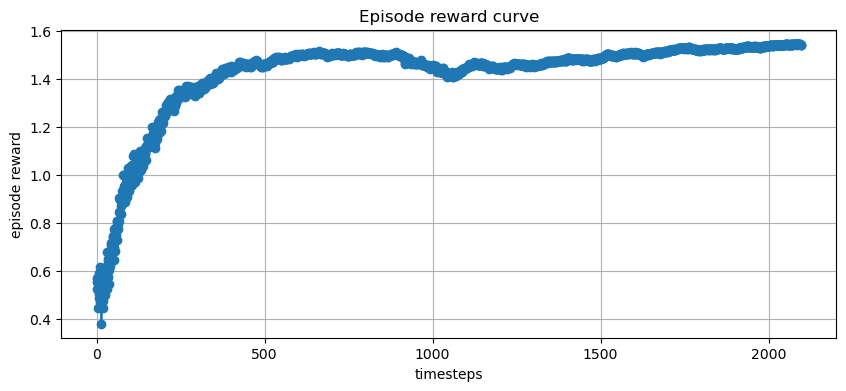

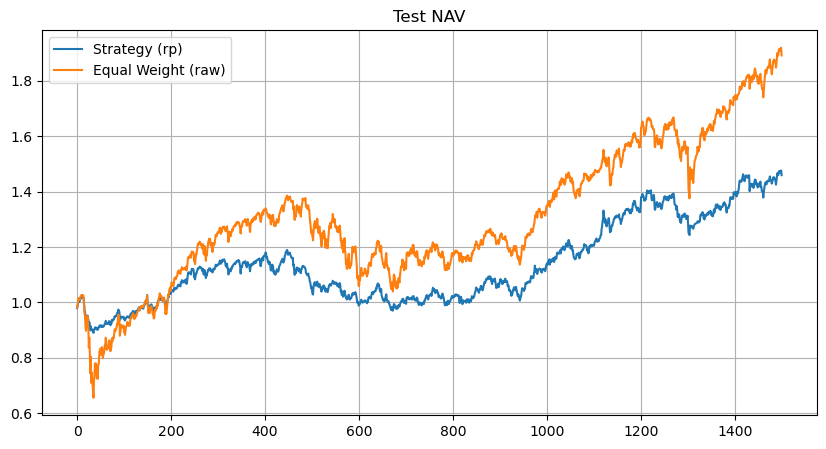

,Strategy,EqualWeight
ann_return,0.065565,0.113029
ann_vol,0.114342,0.207383
sharpe,0.612750,0.620711
max_drawdown,-0.184362,-0.361264


In [77]:
plot_learning_curves(ep_logs, eval_logs)
plot_nav(df_strat, eqw_raw)
summarize(df_strat, eqw_raw)

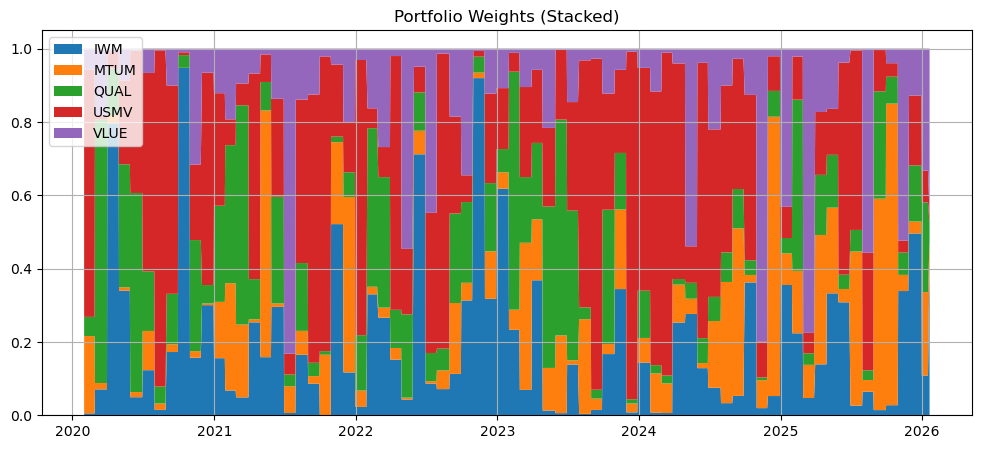

In [76]:
import matplotlib.pyplot as plt

weight_cols = [c for c in df_strat.columns if c.startswith("w_")]
W = df_strat[weight_cols].copy()
W.columns = [c.replace("w_", "") for c in W.columns]

plt.figure(figsize=(12,5))
plt.stackplot(W.index, [W[c].values for c in W.columns], labels=W.columns)
plt.title("Portfolio Weights (Stacked)")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()



In [78]:
def add_rebalance_flag_by_n_days(df_strat: pd.DataFrame, rebalance_every: int) -> pd.DataFrame:
    """
    df_stratに rebalance 列が無い場合に、N日ごとリバランスとして付与。
    """
    df = df_strat.copy()
    if "rebalance" not in df.columns:
        flag = np.zeros(len(df), dtype=bool)
        flag[::rebalance_every] = True
        df["rebalance"] = flag
    return df

def compute_delta_w_tables(
    df_strat: pd.DataFrame,
    rets_te: pd.DataFrame,
    tickers: list,
    use_scaled_return: bool = False,  # Trueなら df_strat["rp"] と整合するスケールを当てる（下で説明）
) -> dict:
    """
    リバランス日に対し
      - Δwランキング
      - Δw×r(t+1)ランキング
    を返す

    ※ df_strat.index は "実現日 (t+1)" の想定
    """
    df = df_strat.copy()
    w_cols = [f"w_{t}" for t in tickers]
    W = df[w_cols].copy()

    # Δw（1日前との差。ホールドなら非リバランス日はほぼ0）
    dW = W.diff()

    # 翌日リターン（実現日ベースで整合）
    R = rets_te.loc[df.index, tickers].copy()

    # スケール後寄与も見たい場合：levがあるならそれを掛ける
    if use_scaled_return and ("lev" in df.columns):
        R_eff = R.mul(df["lev"].values, axis=0)
    else:
        R_eff = R

    contrib = dW * R_eff.values  # Δw_i * r_i(t+1)

    out = {}
    reb_dates = df.index[df["rebalance"].astype(bool)]

    for d in reb_dates:
        dw = dW.loc[d].rename("delta_w").to_frame()
        dw["abs"] = dw["delta_w"].abs()
        dw_rank = dw.sort_values("abs", ascending=False)

        c = contrib.loc[d].rename("delta_w_x_ret").to_frame()
        c["abs"] = c["delta_w_x_ret"].abs()
        c_rank = c.sort_values("abs", ascending=False)

        out[d] = {"delta_w_rank": dw_rank, "delta_w_x_ret_rank": c_rank}

    return out

def risk_contribution_share(w: np.ndarray, Sigma: np.ndarray, eps=1e-12) -> np.ndarray:
    """
    RC_share_i = w_i * (Sigma w)_i / (w' Sigma w)
    """
    sw = Sigma @ w
    denom = float(w @ sw) + eps
    rc = w * sw
    return rc / denom

def compute_delta_rc_tables(
    df_strat: pd.DataFrame,
    rets_te: pd.DataFrame,
    tickers: list,
    window_cov: int = 20,
) -> dict:
    """
    リバランス日に対し ΔRCランキングを返す
    - Σ_t は "意思決定時点 t" までの過去 window_cov で推定
    - df_strat.index は 実現日(t+1)想定なので、意思決定日は1営業日前を使う
    """
    df = df_strat.copy()
    w_cols = [f"w_{t}" for t in tickers]
    W = df[w_cols].copy()

    # 意思決定日 = 実現日の1日前
    # rets_te の営業日で1日前を取る（index整合が重要）
    rets_idx = rets_te.index
    decision_dates = {}
    for d in df.index:
        pos = rets_idx.get_indexer([d])[0]
        if pos <= 0:
            decision_dates[d] = None
        else:
            decision_dates[d] = rets_idx[pos - 1]

    dRC_out = {}
    reb_dates = df.index[df["rebalance"].astype(bool)]

    for d in reb_dates:
        d_prev = df.index[df.index.get_loc(d) - 1] if df.index.get_loc(d) > 0 else None
        if d_prev is None:
            continue

        t_dec = decision_dates[d]
        t_dec_prev = decision_dates[d_prev]
        if (t_dec is None) or (t_dec_prev is None):
            continue

        # Σ_t: 過去window_cov日の共分散（t_decまで）
        R_win = rets_te.loc[:t_dec, tickers].tail(window_cov)
        if len(R_win) < window_cov:
            continue
        Sigma = np.cov(R_win.values, rowvar=False, ddof=0)

        w_new = W.loc[d].values.astype(float)
        w_old = W.loc[d_prev].values.astype(float)

        rc_new = risk_contribution_share(w_new, Sigma)
        rc_old = risk_contribution_share(w_old, Sigma)

        d_rc = rc_new - rc_old
        tab = pd.DataFrame({
            "delta_RC_share": d_rc,
            "abs": np.abs(d_rc)
        }, index=tickers).sort_values("abs", ascending=False)

        dRC_out[d] = tab

    return dRC_out

import torch as th
import torch.nn as nn

class SB3ActorWeights(nn.Module):
    """
    obs -> actor mean -> softmax -> weights
    """
    def __init__(self, sb3_model, tau: float = 1.0):
        super().__init__()
        self.policy = sb3_model.policy
        self.tau = float(tau)
        self.device = self.policy.device

        self.features_extractor = self.policy.features_extractor
        self.mlp_extractor = self.policy.mlp_extractor
        self.action_net = self.policy.action_net
        self.eval()

    def forward(self, obs: th.Tensor) -> th.Tensor:
        obs = obs.to(self.device)
        feat = self.features_extractor(obs)
        latent_pi, _ = self.mlp_extractor(feat)
        a_mean = self.action_net(latent_pi)
        z = a_mean / max(self.tau, 1e-12)
        return th.softmax(z, dim=1)

def integrated_gradients(
    f: nn.Module,
    x: np.ndarray,
    baseline: np.ndarray,
    target_idx: int,
    n_steps: int = 32
) -> np.ndarray:
    """
    IG for output weight[target_idx]
    """
    device = next(f.parameters()).device
    x_t = th.tensor(x[None, :], dtype=th.float32, device=device)
    b_t = th.tensor(baseline[None, :], dtype=th.float32, device=device)

    alphas = th.linspace(0, 1, n_steps, device=device)
    grads = []

    for a in alphas:
        z = b_t + a * (x_t - b_t)
        z.requires_grad_(True)
        y = f(z)[0, target_idx]
        g = th.autograd.grad(y, z, retain_graph=False, create_graph=False)[0]
        grads.append(g.detach())

    avg_grad = th.stack(grads, dim=0).mean(dim=0)
    ig = (x_t - b_t) * avg_grad
    return ig[0].detach().cpu().numpy()

def ig_factor_importance_auto(
    sb3_model,
    obs_t: np.ndarray,
    obs_prev: np.ndarray,
    asset_idx: int,
    lookback: int = 20,
    tau: float = 1.0,
    n_steps: int = 32,
    feat_names = None,
):
    """
    IGを obs_dim/ lookback から自動で (lookback, D_used) にreshape
    """
    f = SB3ActorWeights(sb3_model, tau=tau).to(sb3_model.policy.device).eval()

    ig_vec = integrated_gradients(
        f,
        x=obs_t,
        baseline=obs_prev,
        target_idx=asset_idx,
        n_steps=n_steps
    )

    obs_dim = ig_vec.shape[0]
    assert obs_dim % lookback == 0, f"obs_dim={obs_dim} not divisible by lookback={lookback}"
    D_used = obs_dim // lookback

    ig_mat = ig_vec.reshape(lookback, D_used)

    if (feat_names is None) or (len(feat_names) != D_used):
        feat_names = [f"feat_{j}" for j in range(D_used)]

    # 因子重要度（特徴方向に集約）
    imp_signed = ig_mat.mean(axis=0)
    imp_abs = np.abs(ig_mat).mean(axis=0)

    tab = pd.DataFrame(
        {"IG_signed": imp_signed, "IG_abs": imp_abs},
        index=feat_names
    ).sort_values("IG_abs", ascending=False)

    return ig_mat, tab

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

def fit_surrogate_tree(X: np.ndarray, W: np.ndarray, seed: int = 0):
    """
    X: (n_samples, obs_dim)
    W: (n_samples, n_assets)
    """
    base = RandomForestRegressor(
        n_estimators=300,
        max_depth=6,
        random_state=seed,
        n_jobs=-1
    )
    model = MultiOutputRegressor(base)
    model.fit(X, W)
    return model

def surrogate_shap_one(model_sur, x_one: np.ndarray):
    """
    1サンプルの SHAP（資産ごとに返す）
    """
    import shap
    shap_vals_assets = []
    for k, est in enumerate(model_sur.estimators_):
        expl = shap.TreeExplainer(est)
        sv = expl.shap_values(x_one[None, :])  # (1, obs_dim)
        shap_vals_assets.append(sv[0])
    return shap_vals_assets

def surrogate_shap_feature_importance_auto(
    model_sur,
    x_one: np.ndarray,
    lookback: int,
    feat_names = None,
):
    """
    サロゲートSHAPを資産ごとに返す
    shap_vals_assets[i] は (obs_dim,)。
    それを (lookback, D_used) に変換して特徴方向に集約する
    """
    shap_assets = surrogate_shap_one(model_sur, x_one)  # list[n_assets] of (obs_dim,)

    obs_dim = shap_assets[0].shape[0]
    assert obs_dim % lookback == 0
    D_used = obs_dim // lookback

    if (feat_names is None) or (len(feat_names) != D_used):
        feat_names = [f"feat_{j}" for j in range(D_used)]

    out = {}
    for i, sv in enumerate(shap_assets):
        mat = sv.reshape(lookback, D_used)
        imp = np.abs(mat).mean(axis=0)
        tab = pd.DataFrame({"SHAP_abs": imp}, index=feat_names).sort_values("SHAP_abs", ascending=False)
        out[i] = tab
    return out

def build_obs_matrix_from_features(F: pd.DataFrame, lookback: int = 20) -> (np.ndarray, pd.DatetimeIndex):
    """
    F: (T, D) どんな列数でもOK
    X[t] は index[t] を意思決定日として、過去lookbackをstackしてflatten
    """
    arr = F.to_numpy(dtype=np.float32)
    idx = F.index
    X = []
    out_idx = []
    for t in range(lookback, len(F)):
        X.append(arr[t-lookback:t].reshape(-1))
        out_idx.append(idx[t])
    return np.asarray(X, dtype=np.float32), pd.DatetimeIndex(out_idx)

def explain_rebalance_events(
    sb3_model,
    df_strat: pd.DataFrame,
    rets_te: pd.DataFrame,
    F_te_s: pd.DataFrame,
    tickers: list,
    lookback: int = 20,
    window_cov: int = 20,
    rebalance_every: int = 5,
    tau: float = 1.0,
    use_scaled_return: bool = False,
    topk_assets: int = 3,
    topk_features: int = 10,
    seed: int = 0
):
    df = add_rebalance_flag_by_n_days(df_strat, rebalance_every)

    # --- (1) Δw & Δw×r(t+1)
    tables_dw = compute_delta_w_tables(df, rets_te, tickers, use_scaled_return=use_scaled_return)

    # --- (2) ΔRC
    tables_drc = compute_delta_rc_tables(df, rets_te, tickers, window_cov=window_cov)

    # --- (3) 観測行列（列数Dは自動）
    X_dec, idx_dec = build_obs_matrix_from_features(F_te_s, lookback=lookback)

    # --- サロゲート学習用 (x->w) データ：意思決定日t → realized日t+1のw
    w_cols = [f"w_{t}" for t in tickers]
    W_realized = df[w_cols].copy()

    X_use, W_dec = [], []
    for d in idx_dec:
        pos = rets_te.index.get_indexer([d])[0]
        if pos < 0 or pos+1 >= len(rets_te.index):
            continue
        d_realized = rets_te.index[pos+1]
        if d_realized in W_realized.index:
            X_use.append(X_dec[idx_dec.get_loc(d)])
            W_dec.append(W_realized.loc[d_realized].values.astype(np.float32))
    X_use = np.asarray(X_use, dtype=np.float32)
    W_dec = np.asarray(W_dec, dtype=np.float32)

    sur = fit_surrogate_tree(X_use, W_dec, seed=seed)

    # 特徴名（D_usedと一致しないなら自動化する）
    D_used = X_use.shape[1] // lookback
    feat_names = list(F_te_s.columns)
    if len(feat_names) != D_used:
        feat_names = [f"feat_{j}" for j in range(D_used)]

    report = {}

    for realized_date in df.index[df["rebalance"].astype(bool)]:
        if realized_date not in tables_dw:
            continue

        dw_rank = tables_dw[realized_date]["delta_w_rank"]
        dx_rank = tables_dw[realized_date]["delta_w_x_ret_rank"]
        drc_rank = tables_drc.get(realized_date, None)

        # realized_date の意思決定日は1日前
        pos = rets_te.index.get_indexer([realized_date])[0]
        if pos <= 1:
            continue
        decision_date = rets_te.index[pos-1]
        prev_decision_date = rets_te.index[pos-2]

        if (decision_date not in idx_dec) or (prev_decision_date not in idx_dec):
            continue

        obs_t = X_dec[idx_dec.get_loc(decision_date)]
        obs_prev = X_dec[idx_dec.get_loc(prev_decision_date)]

        # 何を大きく変えたか（ETF上位）
        # dw_rank のindexは "w_MTUM" 形式なので ticker名へ戻す
        top_assets_wcol = dw_rank.index[:topk_assets].tolist()
        top_assets_tkr = [c.replace("w_", "") for c in top_assets_wcol]

        # WHY (IG): top変更ETFについて「特徴の上位」を出す
        why_ig = {}
        for tkr in top_assets_tkr:
            if tkr not in tickers:
                continue
            asset_idx = tickers.index(tkr)
            _, tab_ig = ig_factor_importance_auto(
                sb3_model,
                obs_t=obs_t,
                obs_prev=obs_prev,
                asset_idx=asset_idx,
                lookback=lookback,
                tau=tau,
                n_steps=32,
                feat_names=feat_names
            )
            why_ig[tkr] = tab_ig.head(topk_features)

        # WHY (Surrogate SHAP): 全ETFの上位特徴
        shap_tabs = surrogate_shap_feature_importance_auto(
            sur,
            x_one=obs_t,
            lookback=lookback,
            feat_names=feat_names
        )
        why_shap = {tickers[i]: shap_tabs[i].head(topk_features) for i in range(len(tickers))}

        report[realized_date] = {
            "delta_w_rank": dw_rank,
            "delta_w_x_ret_rank": dx_rank,
            "delta_RC_rank": drc_rank,
            "WHY_IG_top_changed_assets": why_ig,
            "WHY_surrogate_SHAP_all_assets": why_shap,
        }

    return report


In [79]:
rebalance_every = 5  # 例：週次相当
report = explain_rebalance_events(
    sb3_model=model,
    df_strat=df_strat,
    rets_te=R_te[TICKERS],     # ←ここはあなたの変数でOK
    F_te_s=F_te_s,             # ←列数8でも8×5でもOK
    tickers=TICKERS,
    lookback=20,
    window_cov=20,
    rebalance_every=rebalance_every,
    tau=1.0,
    use_scaled_return=True,
    topk_assets=3,
    topk_features=10,
    seed=0
)

d0 = list(report.keys())[0]
print("=== Rebalance realized date:", d0, "===")
display(report[d0]["delta_w_rank"].head(10))
display(report[d0]["delta_w_x_ret_rank"].head(10))
display(report[d0]["delta_RC_rank"].head(10))

print("\n--- WHY (IG: top changed assets) ---")
for a, tab in report[d0]["WHY_IG_top_changed_assets"].items():
    print(f"\n[IG] asset={a}")
    display(tab)

print("\n--- WHY (Surrogate SHAP: all assets) ---")
for a, tab in report[d0]["WHY_surrogate_SHAP_all_assets"].items():
    print(f"\n[SHAP] asset={a}")
    display(tab)


=== Rebalance realized date: 2020-02-07 00:00:00 ===


,delta_w,abs
w_MTUM,0.0,0.0
w_VLUE,0.0,0.0
w_QUAL,0.0,0.0
w_USMV,0.0,0.0
w_IWM,0.0,0.0


,delta_w_x_ret,abs
w_MTUM,-0.0,0.0
w_VLUE,-0.0,0.0
w_QUAL,-0.0,0.0
w_USMV,-0.0,0.0
w_IWM,-0.0,0.0


,delta_RC_share,abs
MTUM,0.0,0.0
VLUE,0.0,0.0
QUAL,0.0,0.0
USMV,0.0,0.0
IWM,0.0,0.0



--- WHY (IG: top changed assets) ---

[IG] asset=MTUM


,IG_signed,IG_abs
vol_cs_MTUM,0.000080,0.000854
vol_cs_IWM,-0.000225,0.000748
dd_cs_MTUM,0.000009,0.000717
dd_cs_USMV,-0.000169,0.000602
dd_cs_QUAL,0.000263,0.000544
dd_cs_VLUE,-0.000069,0.000523
dd_cs_IWM,-0.000080,0.000476
vol_cs_VLUE,-0.000101,0.000426
ma_cs_QUAL,0.000338,0.000338
vol_cs_QUAL,0.000228,0.000302



[IG] asset=VLUE


,IG_signed,IG_abs
vol_cs_IWM,-0.000696,0.002002
dd_cs_MTUM,0.000066,0.001519
vol_cs_VLUE,0.000349,0.001299
dd_cs_USMV,0.000494,0.000902
dd_cs_QUAL,0.000388,0.000834
dd_cs_IWM,-0.000019,0.000814
vol_cs_QUAL,-0.000102,0.000664
dd_cs_VLUE,0.000159,0.000605
ma_dev_USMV,-0.000082,0.000491
vol_cs_USMV,-0.000022,0.000466



[IG] asset=QUAL


,IG_signed,IG_abs
dd_cs_MTUM,-0.000429,0.008293
vol_cs_IWM,0.004935,0.007645
vol_cs_VLUE,-0.001837,0.005956
dd_cs_QUAL,-0.001043,0.005149
dd_cs_USMV,-0.002020,0.005041
dd_cs_VLUE,-0.002701,0.004461
dd_cs_IWM,0.000037,0.003945
vol_cs_QUAL,0.000436,0.003521
vol_cs_MTUM,0.000756,0.002996
ma_dev_MTUM,0.000777,0.002720



--- WHY (Surrogate SHAP: all assets) ---

[SHAP] asset=MTUM


,SHAP_abs
vol_USMV,0.002230
ma_dev_USMV,0.001642
vol_cs_MTUM,0.000840
dd_cs_VLUE,0.000834
vol_MTUM,0.000640
ma_dev_IWM,0.000620
vol_QUAL,0.000596
ma_dev_QUAL,0.000508
ma_cs_IWM,0.000301
dd_VLUE,0.000289



[SHAP] asset=VLUE


,SHAP_abs
mom_MTUM,0.005267
vol_MTUM,0.002812
vol_QUAL,0.001217
vol_IWM,0.000805
vol_cs_QUAL,0.000773
mom_VLUE,0.000654
vol_USMV,0.000558
vol_VLUE,0.000420
ma_dev_QUAL,0.000353
ma_dev_USMV,0.000330



[SHAP] asset=QUAL


,SHAP_abs
vol_VLUE,0.004407
vol_cs_MTUM,0.001130
vol_MTUM,0.001000
vol_IWM,0.000826
dd_IWM,0.000656
ma_dev_USMV,0.000452
ma_dev_IWM,0.000404
vol_USMV,0.000359
ma_dev_MTUM,0.000307
dd_cs_QUAL,0.000305



[SHAP] asset=USMV


,SHAP_abs
vol_IWM,0.003630
vol_USMV,0.003573
ma_dev_USMV,0.002132
vol_VLUE,0.001192
ma_dev_QUAL,0.001124
ma_dev_MTUM,0.001020
ma_cs_MTUM,0.001013
ma_cs_VLUE,0.000993
mom_MTUM,0.000575
dd_MTUM,0.000481



[SHAP] asset=IWM


,SHAP_abs
vol_MTUM,0.003772
vol_USMV,0.003101
vol_cs_IWM,0.002056
ma_dev_USMV,0.000679
dd_USMV,0.000590
dd_QUAL,0.000499
mom_cs_VLUE,0.000417
vol_QUAL,0.000268
ma_cs_VLUE,0.000252
mom_MTUM,0.000241


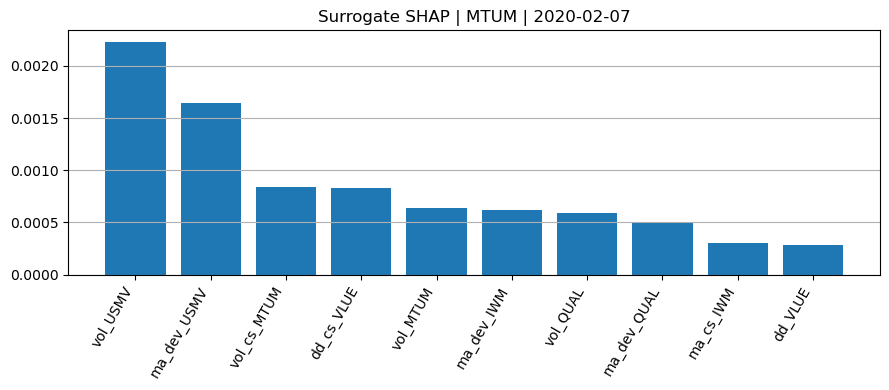

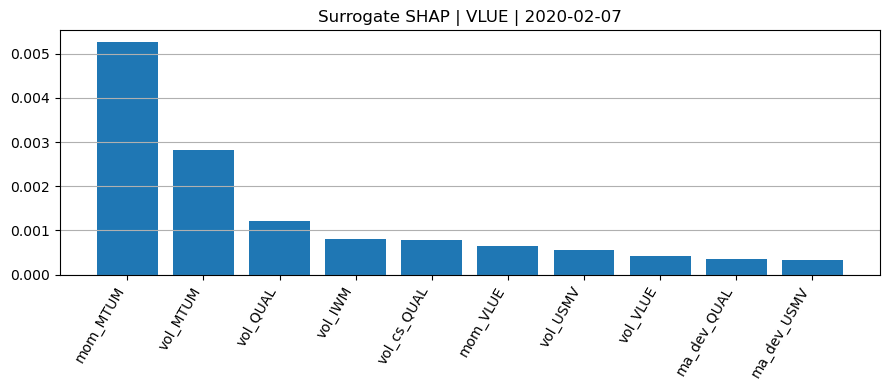

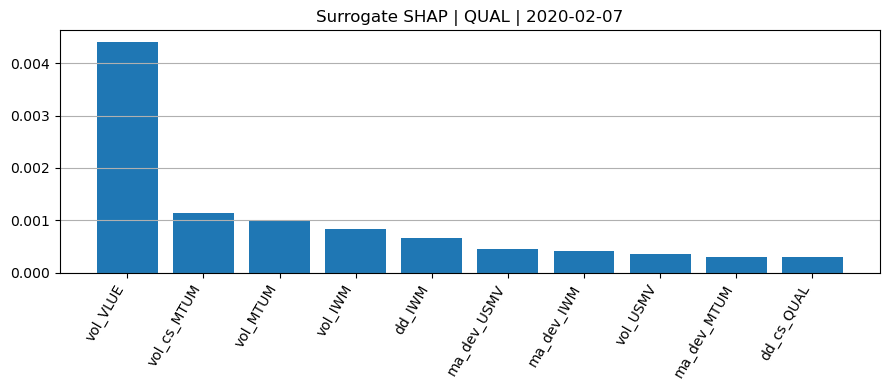

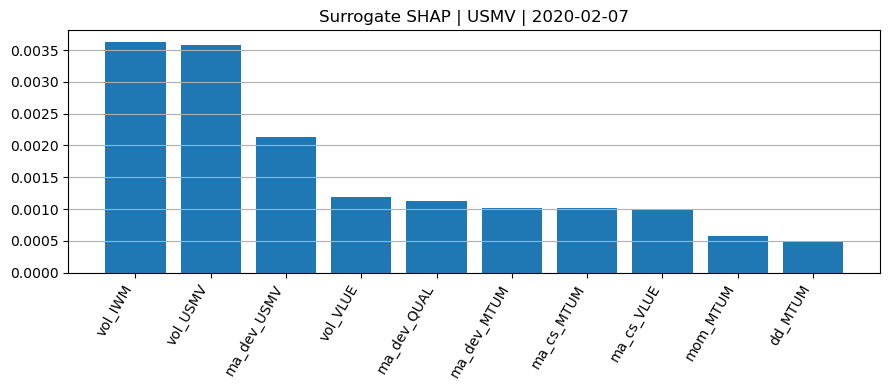

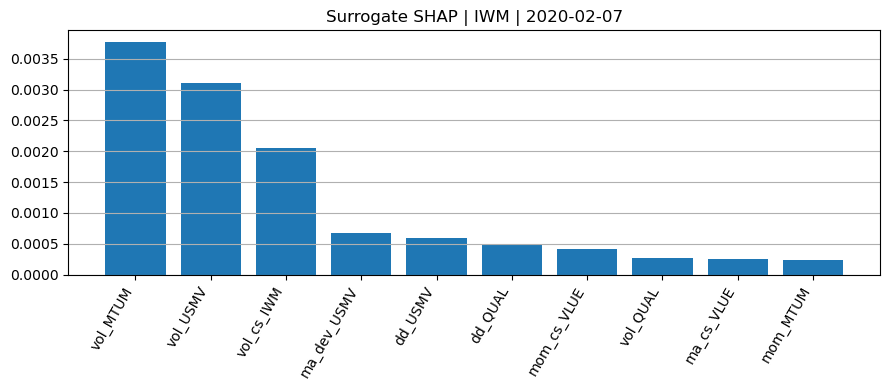

In [80]:
import matplotlib.pyplot as plt

def plot_shap_bar_one(report, date, ticker, topk=20, title_prefix="Surrogate SHAP"):
    tab = report[date]["WHY_surrogate_SHAP_all_assets"][ticker].copy()
    tab = tab.sort_values("SHAP_abs", ascending=False).head(topk)

    plt.figure(figsize=(9, 4))
    plt.bar(range(len(tab)), tab["SHAP_abs"].values)
    plt.xticks(range(len(tab)), tab.index.tolist(), rotation=60, ha="right")
    plt.title(f"{title_prefix} | {ticker} | {date.date()}")
    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()

for tkr in TICKERS:
    plot_shap_bar_one(report, d0, tkr, topk=12)



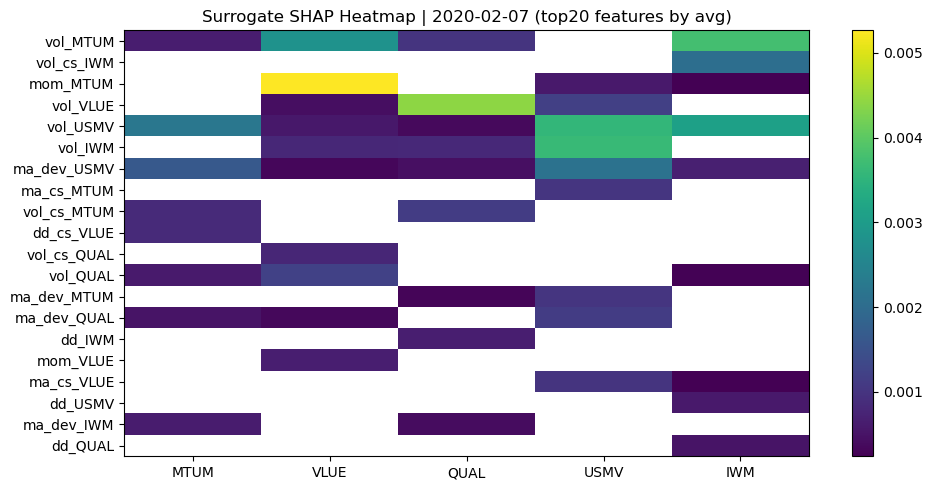

In [81]:

def plot_shap_heatmap_assets_features(report, date, tickers, topk=20, title_prefix="Surrogate SHAP"):
    # まず全ETFのSHAP_absを結合
    tabs = []
    for tkr in tickers:
        tab = report[date]["WHY_surrogate_SHAP_all_assets"][tkr][["SHAP_abs"]].rename(columns={"SHAP_abs": tkr})
        tabs.append(tab)

    M = pd.concat(tabs, axis=1)  # index=feature, columns=tickers

    # 上位特徴（ETF平均で選ぶ）
    feat_order = M.mean(axis=1).sort_values(ascending=False).head(topk).index
    M = M.loc[feat_order]

    plt.figure(figsize=(10, 5))
    plt.imshow(M.values, aspect="auto")
    plt.colorbar()
    plt.yticks(range(len(M.index)), M.index.tolist())
    plt.xticks(range(len(M.columns)), M.columns.tolist())
    plt.title(f"{title_prefix} Heatmap | {date.date()} (top{topk} features by avg)")
    plt.tight_layout()
    plt.show()

plot_shap_heatmap_assets_features(report, d0, TICKERS, topk=20)


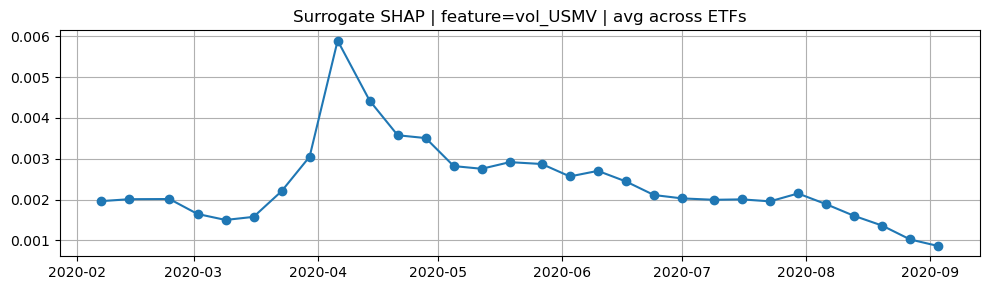

In [82]:
def plot_shap_timeseries_feature(report, dates, tickers, feature_name, title_prefix="Surrogate SHAP"):
    ys = []
    for d in dates:
        vals = []
        for tkr in tickers:
            tab = report[d]["WHY_surrogate_SHAP_all_assets"][tkr]
            if feature_name in tab.index:
                vals.append(float(tab.loc[feature_name, "SHAP_abs"]))
        ys.append(np.mean(vals) if len(vals) else np.nan)

    plt.figure(figsize=(10, 3))
    plt.plot(dates, ys, marker="o")
    plt.title(f"{title_prefix} | feature={feature_name} | avg across ETFs")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

dates_sorted = sorted(report.keys())
# 例：一番重要そうな特徴を1つ拾う（MTUMのトップ特徴）
feat0 = report[d0]["WHY_surrogate_SHAP_all_assets"]["MTUM"].index[0]
plot_shap_timeseries_feature(report, dates_sorted[:30], TICKERS, feat0)


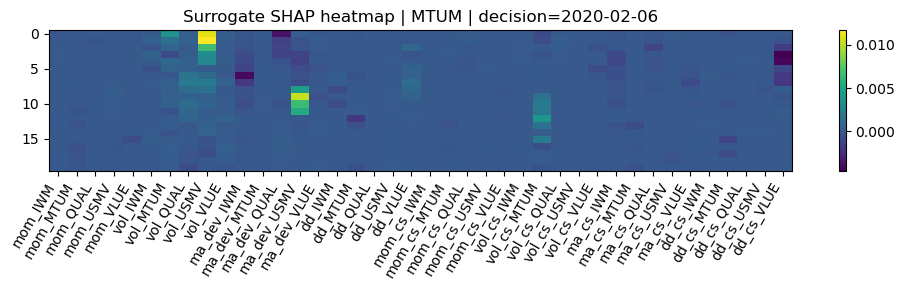

In [83]:
def plot_surrogate_shap_lookback_heatmap(model_sur, x_one, lookback, asset_idx=0, feat_names=None, title="Surrogate SHAP (lookback×feat)"):
    import shap
    est = model_sur.estimators_[asset_idx]
    expl = shap.TreeExplainer(est)
    sv = expl.shap_values(x_one[None, :])[0]  # (obs_dim,)

    obs_dim = sv.shape[0]
    assert obs_dim % lookback == 0
    D = obs_dim // lookback
    mat = sv.reshape(lookback, D)

    if feat_names is None or len(feat_names) != D:
        feat_names = [f"feat_{j}" for j in range(D)]

    plt.figure(figsize=(10, 3))
    plt.imshow(mat, aspect="auto")
    plt.colorbar()
    plt.xticks(range(D), feat_names, rotation=60, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()

pos = R_te.index.get_indexer([d0])[0]
decision_date = R_te.index[pos - 1]   # 1日前が意思決定日
lookback = 20

X_dec, idx_dec = build_obs_matrix_from_features(F_te_s, lookback=lookback)

# 意思決定日 decision_date に対応する観測ベクトル
obs_t = X_dec[idx_dec.get_loc(decision_date)]

w_cols = [f"w_{t}" for t in TICKERS]
W_realized = df_strat[w_cols].copy()

X_use, W_dec = [], []
for d in idx_dec:
    p = R_te.index.get_indexer([d])[0]
    if p < 0 or p + 1 >= len(R_te.index):
        continue
    d_realized = R_te.index[p + 1]
    if d_realized in W_realized.index:
        X_use.append(X_dec[idx_dec.get_loc(d)])
        W_dec.append(W_realized.loc[d_realized].values.astype(np.float32))

X_use = np.asarray(X_use, dtype=np.float32)
W_dec = np.asarray(W_dec, dtype=np.float32)

sur = fit_surrogate_tree(X_use, W_dec, seed=0)

asset_idx = 0  # MTUM

# feat_names は “1日分の特徴D個” の名前が必要（D = obs_dim/lookback）
# F_te_s.columns が D と一致するならそのまま使える
plot_surrogate_shap_lookback_heatmap(
    model_sur=sur,
    x_one=obs_t,
    lookback=lookback,
    asset_idx=asset_idx,
    feat_names=list(F_te_s.columns),  # 一致しない場合は自動で feat_0.. になる
    title=f"Surrogate SHAP heatmap | {TICKERS[asset_idx]} | decision={decision_date.date()}"
)


In [84]:
TICKERS

['MTUM', 'VLUE', 'QUAL', 'USMV', 'IWM']

/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_20906/1989148154.py:43: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv_agg, X_agg, feature_names=feat_names, show=True)


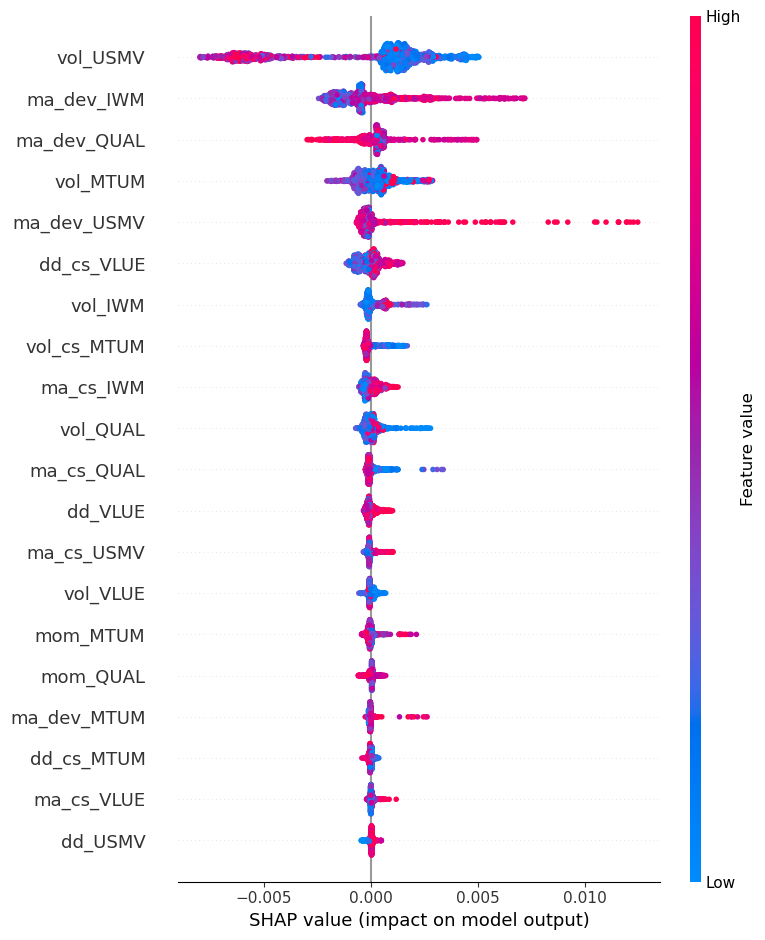

In [85]:
import shap
import numpy as np

def shap_summary_beeswarm_for_asset(
    model_sur,
    X: np.ndarray,
    lookback: int,
    asset_idx: int = 0,
    feat_names=None,
    max_samples: int = 2000,
    seed: int = 0
):
    """
    一般的な SHAP summary plot (beeswarm) を描く
    - asset_idx: どのETFウェイトを説明するか
    """
    rng = np.random.default_rng(seed)
    if X.shape[0] > max_samples:
        idx = rng.choice(X.shape[0], size=max_samples, replace=False)
        Xp = X[idx]
    else:
        Xp = X

    est = model_sur.estimators_[asset_idx]
    expl = shap.TreeExplainer(est)
    sv = expl.shap_values(Xp)  # (n_samples, obs_dim)

    obs_dim = Xp.shape[1]
    assert obs_dim % lookback == 0
    D = obs_dim // lookback

    # ---- 特徴名：1日分D個の特徴名を渡す（無ければ自動）
    if feat_names is None or len(feat_names) != D:
        feat_names = [f"feat_{j}" for j in range(D)]

    # ---- lookback方向に平均して「一般的な特徴D個」に集約する
    sv_mat = sv.reshape(Xp.shape[0], lookback, D)
    X_mat  = Xp.reshape(Xp.shape[0], lookback, D)

    sv_agg = sv_mat.mean(axis=1)         # (n, D)
    X_agg  = X_mat.mean(axis=1)          # (n, D)

    shap.summary_plot(sv_agg, X_agg, feature_names=feat_names, show=True)

asset_idx = 0  # 0:MTUM
shap_summary_beeswarm_for_asset(
    model_sur=sur,
    X=X_use,
    lookback=20,
    asset_idx=asset_idx,
    feat_names=list(F_te_s.columns)  # もしDと一致するなら
)


/var/folders/3n/5qpgng455w713g5kj65vkyq80000gn/T/ipykernel_20906/1460264857.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv_agg, features=None, feature_names=feat_names, plot_type="bar", show=True)


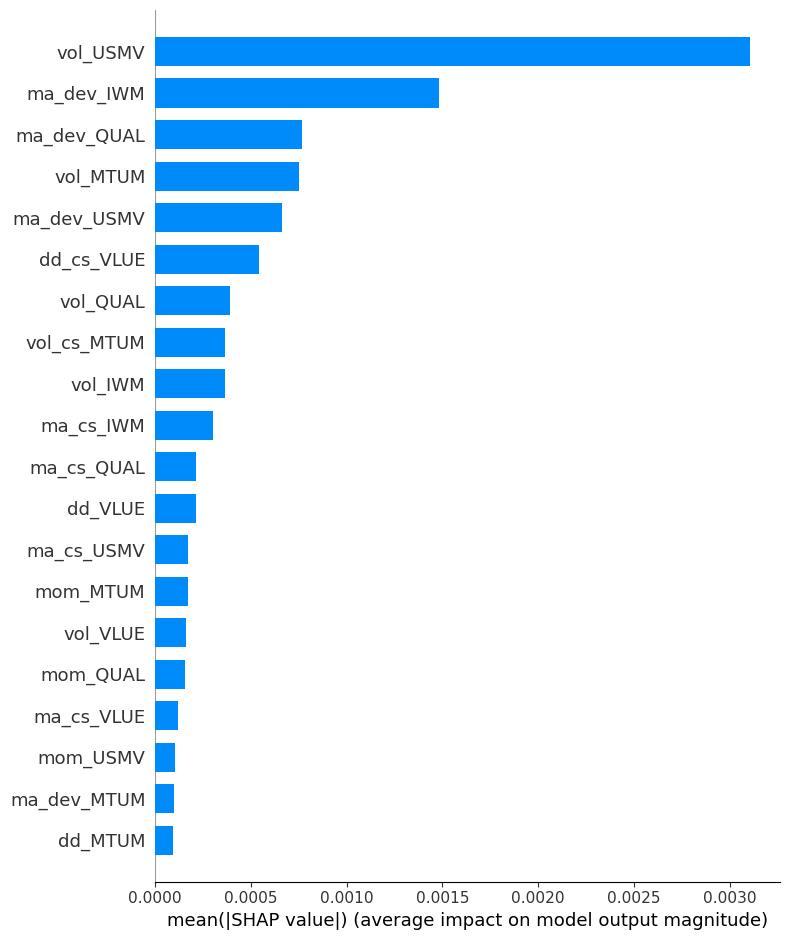

In [86]:
def shap_summary_bar_for_asset(model_sur, X, lookback, asset_idx=0, feat_names=None, max_samples=2000, seed=0):
    import shap
    import numpy as np

    rng = np.random.default_rng(seed)
    if X.shape[0] > max_samples:
        idx = rng.choice(X.shape[0], size=max_samples, replace=False)
        Xp = X[idx]
    else:
        Xp = X

    est = model_sur.estimators_[asset_idx]
    expl = shap.TreeExplainer(est)
    sv = expl.shap_values(Xp)  # (n, obs_dim)

    obs_dim = Xp.shape[1]
    assert obs_dim % lookback == 0
    D = obs_dim // lookback

    if feat_names is None or len(feat_names) != D:
        feat_names = [f"feat_{j}" for j in range(D)]

    sv_mat = sv.reshape(Xp.shape[0], lookback, D)
    sv_agg = np.abs(sv_mat).mean(axis=1)  # (n, D)

    shap.summary_plot(sv_agg, features=None, feature_names=feat_names, plot_type="bar", show=True)

shap_summary_bar_for_asset(sur, X_use, lookback=20, asset_idx=asset_idx, feat_names=list(F_te_s.columns))


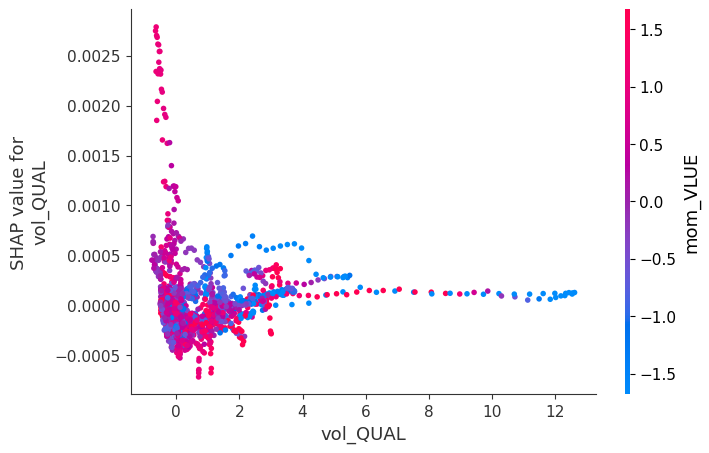

In [87]:
def shap_dependence_for_asset(model_sur, X, lookback, asset_idx, feat_name, feat_names=None, max_samples=2000, seed=0):
    import shap
    import numpy as np

    rng = np.random.default_rng(seed)
    if X.shape[0] > max_samples:
        idx = rng.choice(X.shape[0], size=max_samples, replace=False)
        Xp = X[idx]
    else:
        Xp = X

    est = model_sur.estimators_[asset_idx]
    expl = shap.TreeExplainer(est)
    sv = expl.shap_values(Xp)

    obs_dim = Xp.shape[1]
    assert obs_dim % lookback == 0
    D = obs_dim // lookback

    if feat_names is None or len(feat_names) != D:
        feat_names = [f"feat_{j}" for j in range(D)]

    sv_mat = sv.reshape(Xp.shape[0], lookback, D)
    X_mat  = Xp.reshape(Xp.shape[0], lookback, D)

    sv_agg = sv_mat.mean(axis=1)
    X_agg  = X_mat.mean(axis=1)

    shap.dependence_plot(feat_name, sv_agg, X_agg, feature_names=feat_names, show=True)

shap_dependence_for_asset(sur, X_use, 20, asset_idx=asset_idx, feat_name="vol_QUAL", feat_names=list(F_te_s.columns))
